# Background

The shape of outputs in integrated gradients suggests that IG may overestimate some attribution values due to saturated gradients at interpolated inputs. To confirm this, we run SplitIG (which cuts off the interpolated inputs if the gradients are saturated) and examine the level of agreement.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pandas as pd
import numpy as np

from functools import partial
from typing import Optional

from transformer_lens.utils import get_act_name, get_device
from transformer_lens import ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint

import seaborn as sns
import matplotlib.pyplot as plt

from utils import Task, TaskDataset, logit_diff_metric, run_from_layer_fn, plot_attn_comparison, plot_correlation
from split_ig import SplitLayerIntegratedGradients


/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set up Split IG

In [38]:
def compute_layer_to_output_attributions_split_ig(
    original_input, 
    layer_input, 
    layer_baseline, 
    target_layer, 
    prev_layer, 
    metric, 
    metric_labels, 
    ratio=0.95
):
    n_samples = original_input.size(0)

    # Take the model starting from the target layer
    forward_fn = lambda x: run_from_layer_fn(model, original_input, prev_layer, x, metric, metric_labels)

    # Attribute to the target_layer's output
    split_ig = SplitLayerIntegratedGradients(forward_fn, target_layer, multiply_by_inputs=True)
    attributions = split_ig.attribute(inputs=layer_input,
                                    baselines=layer_baseline,
                                    internal_batch_size=n_samples,
                                    attribute_to_layer_input=False,
                                    return_convergence_delta=False)
    grads, outputs, steps, scaled_features = attributions
    grads = grads.reshape((-1, 50,) + grads.shape[1:])
    outputs = outputs.reshape((-1, 50))

    # Calculate threshold for split integrated gradients
    baseline_out = forward_fn(layer_baseline)
    final_out = forward_fn(layer_input)
    threshold = baseline_out + ratio * (final_out - baseline_out)
    threshold = threshold.unsqueeze(-1)

    print(outputs.shape, threshold.shape)
    
    mask = outputs > threshold
    threshold_indices = mask.int().argmax(dim=1)

    # print(outputs.shape, threshold.shape) 
    # for i in range(len(theshold)):
    #     print(outputs[i])
    #     if outputs[i] > threshold:
    #         threshold_index = i
    #         break

    print(threshold_indices.shape) # [10]
    print(grads.shape) # [10, 50, 21, 12, 768]

    # Grads have already been scaled and multiplied by inputs
    n_samples = threshold_indices.size(0)
    left_igs = torch.zeros((n_samples,) + grads.shape[2:])
    right_igs = torch.zeros((n_samples,)+ grads.shape[2:])
    for i in range(threshold_indices.size(0)):
        threshold_index = threshold_indices[i]
        left_igs[i] = grads[i, :threshold_index].sum(dim=0)
        right_igs[i] = grads[i, threshold_index:].sum(dim=0)

    return left_igs, right_igs, threshold_indices

In [4]:
def split_integrated_gradients(model: HookedTransformer, clean_tokens: torch.Tensor, clean_cache: ActivationCache, corrupted_cache: ActivationCache, metric: callable, metric_labels):
    n_samples = clean_tokens.size(0)
    
    # Gradient attribution for neurons in MLP layers
    mlp_results = torch.zeros(n_samples, model.cfg.n_layers, model.cfg.d_mlp)
    # Gradient attribution for attention heads
    attn_results = torch.zeros(n_samples, model.cfg.n_layers, model.cfg.n_heads)

    # Calculate integrated gradients for each layer
    for layer in range(model.cfg.n_layers):

        # Gradient attribution on heads
        hook_name = get_act_name("result", layer)
        target_layer = model.hook_dict[hook_name]
        prev_layer_hook = get_act_name("z", layer)
        prev_layer = model.hook_dict[prev_layer_hook]

        layer_clean_input = clean_cache[prev_layer_hook]
        layer_corrupt_input = corrupted_cache[prev_layer_hook]

        # Shape [batch, seq_len, d_head, d_model]
        left_ig, right_ig, _ = compute_layer_to_output_attributions_split_ig(
            clean_tokens, layer_corrupt_input, layer_clean_input, target_layer, prev_layer, metric, metric_labels)

        # Calculate attribution score based on mean over each embedding, for each token
        per_token_score = left_ig.mean(dim=3)
        score = per_token_score.mean(dim=1)
        attn_results[:, layer] = score

        # Gradient attribution on MLP neurons
        hook_name = get_act_name("post", layer)
        target_layer = model.hook_dict[hook_name]
        prev_layer_hook = get_act_name("mlp_in", layer)
        prev_layer = model.hook_dict[prev_layer_hook]

        layer_clean_input = clean_cache[prev_layer_hook]
        layer_corrupt_input = corrupted_cache[prev_layer_hook]
        
        # Shape [batch, seq_len, d_model]
        left_ig, right_ig, _ = compute_layer_to_output_attributions_split_ig(
            clean_tokens, layer_corrupt_input, layer_clean_input, target_layer, prev_layer, metric, metric_labels)
        score = left_ig.mean(dim=1)
        mlp_results[:, layer] = score

    return mlp_results, attn_results

# Split IG and IOI

In [5]:
torch.set_grad_enabled(False)

device = get_device()
# device = torch.device("cpu")
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


In [10]:
ioi_dataset = TaskDataset(Task.IOI)
ioi_dataloader = ioi_dataset.to_dataloader(batch_size=10)

In [11]:
clean_input, corrupted_input, labels = next(iter(ioi_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-0.0307, -0.9269, -0.4937,  2.2320,  0.6754,  4.0447, -0.1785,  1.1947,
         1.1514,  1.7507], device='cuda:0')
Corrupted logit difference: tensor([-0.0387, -0.9451, -0.5103,  2.2153,  0.6299, -3.2074, -0.1823,  1.1766,
        -3.0072,  1.7392], device='cuda:0')


In [39]:
ioi_split_ig_mlp, ioi_split_ig_attn = split_integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(ioi_split_ig_mlp, "saved_results/ioi_split_ig_mlp.pt")
torch.save(ioi_split_ig_attn, "saved_results/ioi_split_ig_attn.pt")

torch.Size([10, 50]) torch.Size([10, 1])
torch.Size([10])
torch.Size([10, 50, 21, 12, 768])
torch.Size([10, 50]) torch.Size([10, 1])
torch.Size([10])
torch.Size([10, 50, 21, 3072])
torch.Size([10, 50]) torch.Size([10, 1])
torch.Size([10])
torch.Size([10, 50, 21, 12, 768])
torch.Size([10, 50]) torch.Size([10, 1])
torch.Size([10])
torch.Size([10, 50, 21, 3072])
torch.Size([10, 50]) torch.Size([10, 1])
torch.Size([10])
torch.Size([10, 50, 21, 12, 768])
torch.Size([10, 50]) torch.Size([10, 1])
torch.Size([10])
torch.Size([10, 50, 21, 3072])
torch.Size([10, 50]) torch.Size([10, 1])
torch.Size([10])
torch.Size([10, 50, 21, 12, 768])
torch.Size([10, 50]) torch.Size([10, 1])
torch.Size([10])
torch.Size([10, 50, 21, 3072])
torch.Size([10, 50]) torch.Size([10, 1])
torch.Size([10])
torch.Size([10, 50, 21, 12, 768])
torch.Size([10, 50]) torch.Size([10, 1])
torch.Size([10])
torch.Size([10, 50, 21, 3072])
torch.Size([10, 50]) torch.Size([10, 1])
torch.Size([10])
torch.Size([10, 50, 21, 12, 768])
tor

In [8]:
ioi_split_ig_mlp = torch.load("saved_results/ioi_split_ig_mlp.pt")
ioi_split_ig_attn = torch.load("saved_results/ioi_split_ig_attn.pt")

ioi_ap_mlp = torch.load("saved_results/ioi_ap_mlp.pt")
ioi_ap_attn = torch.load("saved_results/ioi_ap_attn.pt")

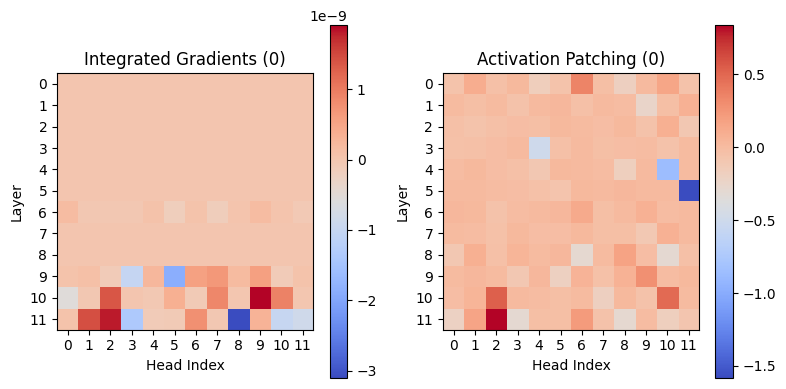

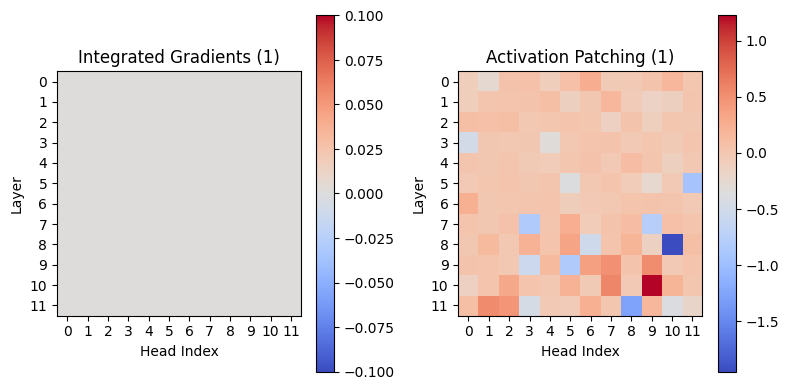

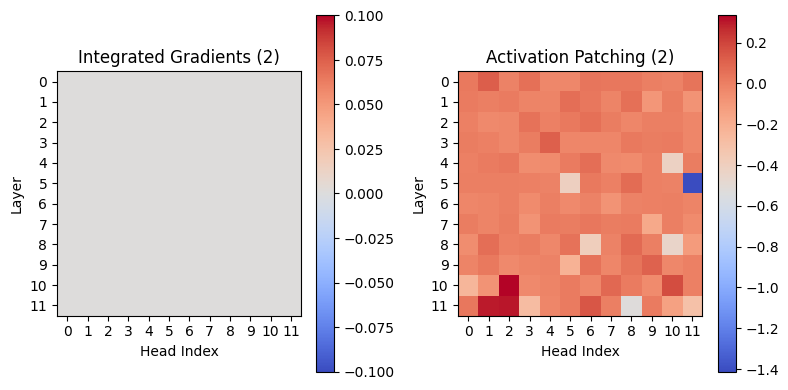

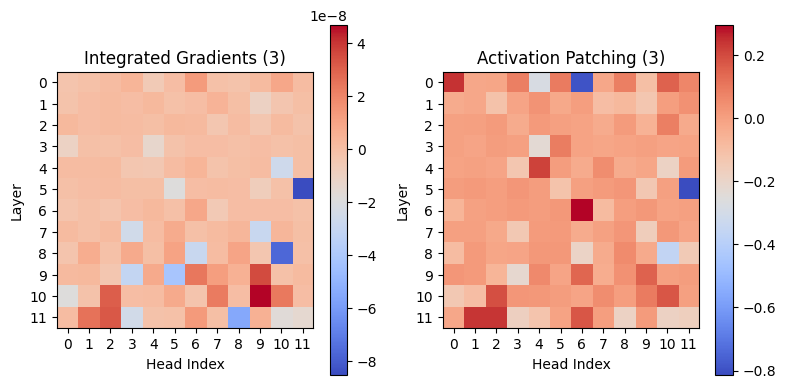

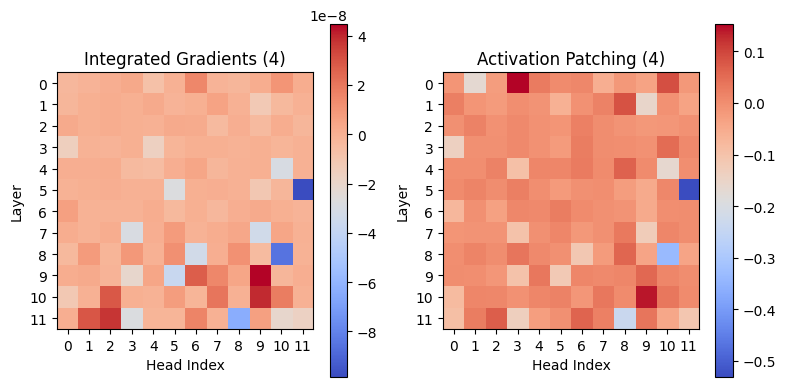

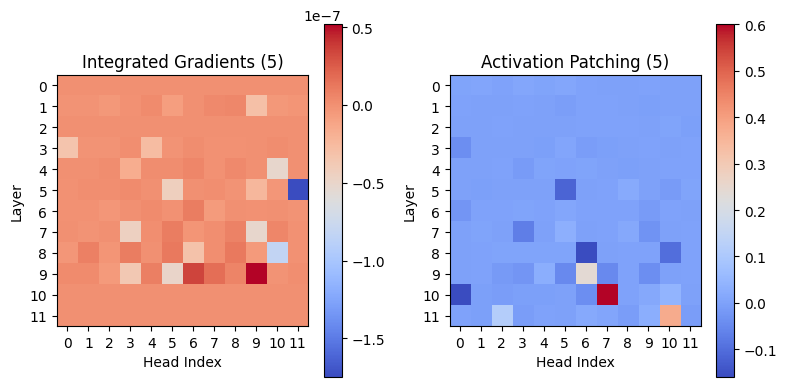

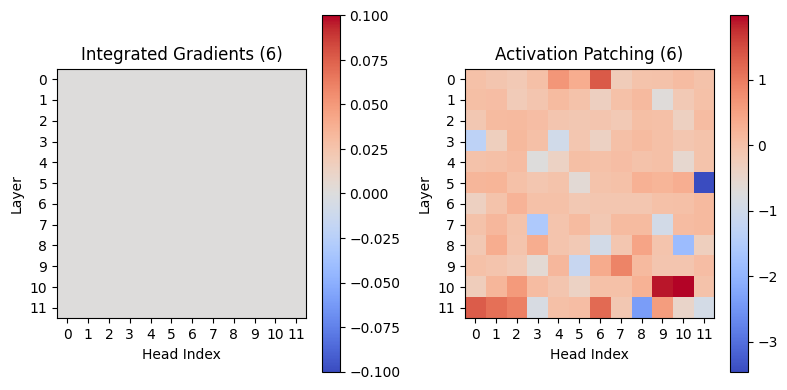

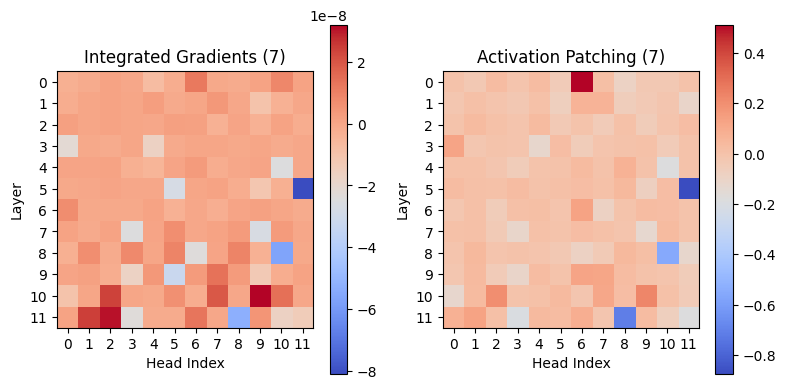

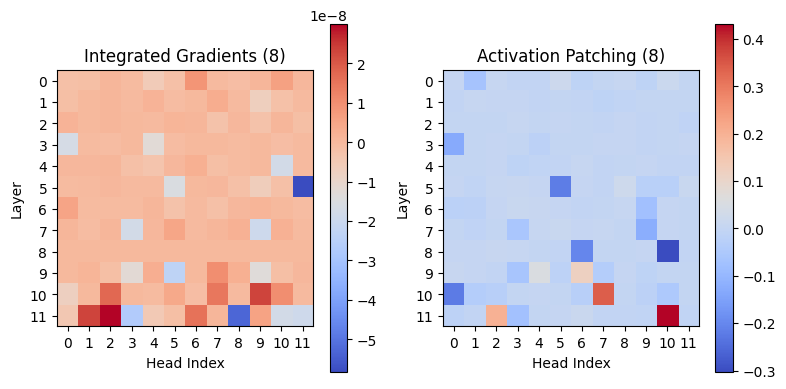

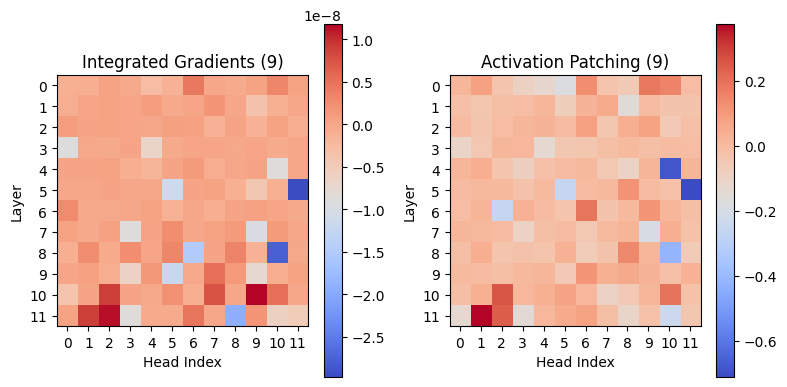

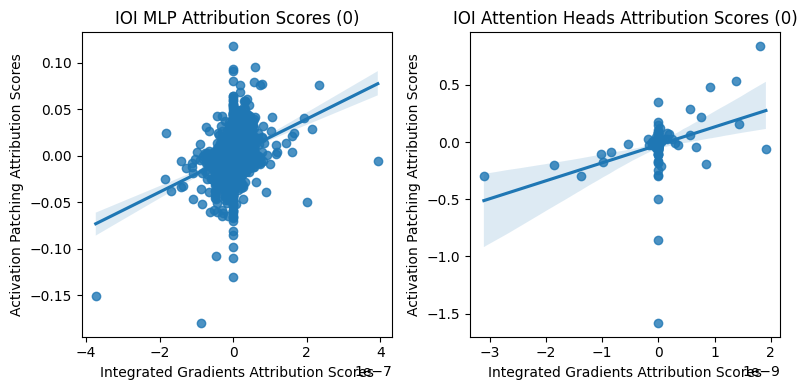

Correlation coefficient for neurons: 0.27940817743958524
Correlation coefficient for attention heads: 0.37140015542136


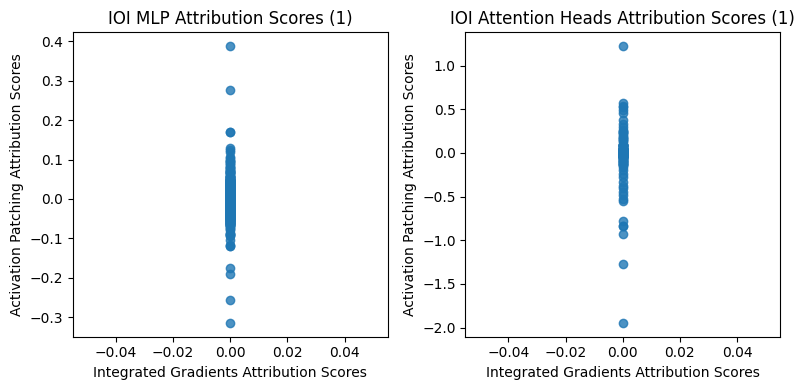

/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Correlation coefficient for neurons: nan
Correlation coefficient for attention heads: nan


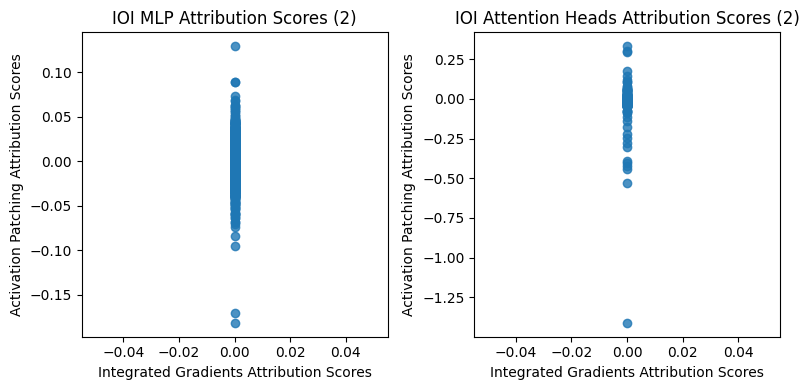

Correlation coefficient for neurons: nan
Correlation coefficient for attention heads: nan


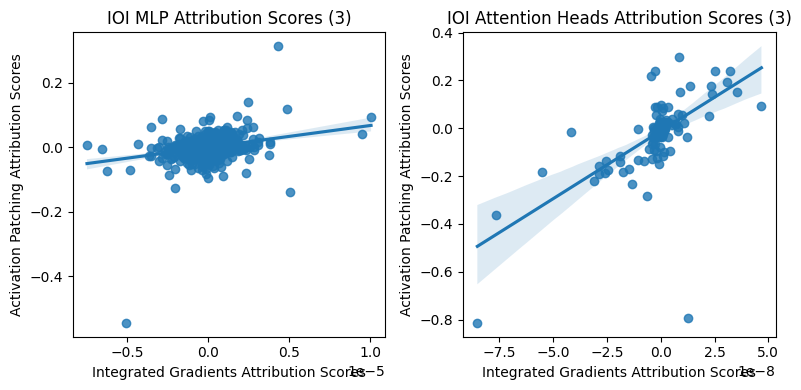

Correlation coefficient for neurons: 0.3049634169481414
Correlation coefficient for attention heads: 0.6441496874286066


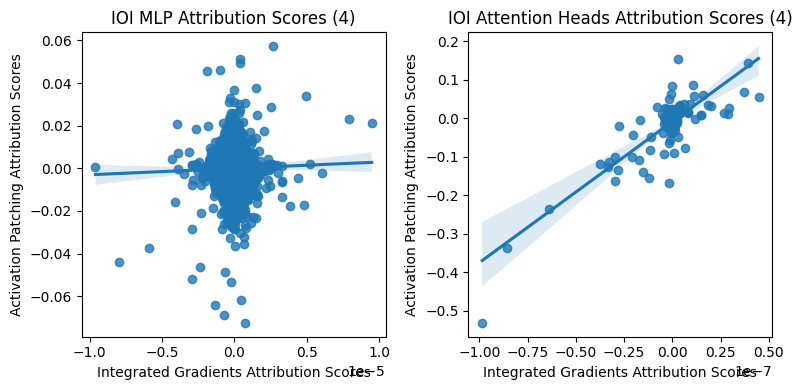

Correlation coefficient for neurons: 0.028050866090226768
Correlation coefficient for attention heads: 0.8348532352232813


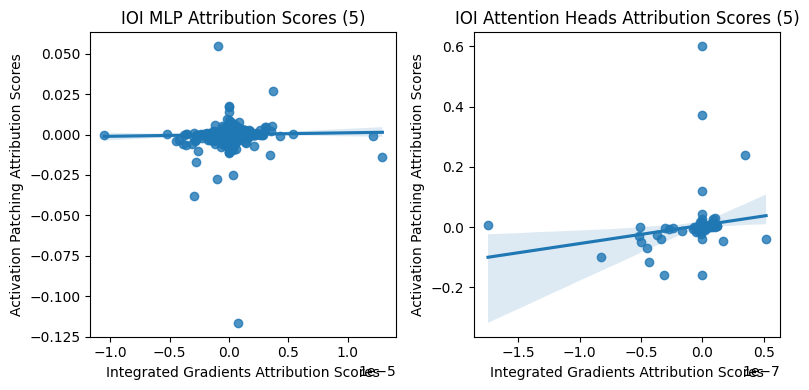

Correlation coefficient for neurons: 0.029850255146698593
Correlation coefficient for attention heads: 0.18061408635075574


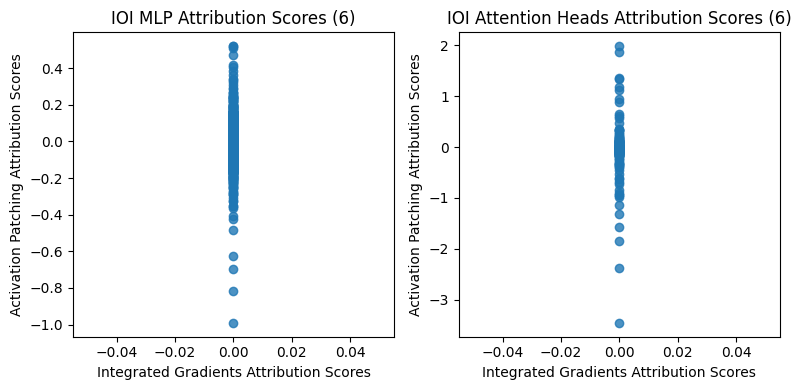

Correlation coefficient for neurons: nan
Correlation coefficient for attention heads: nan


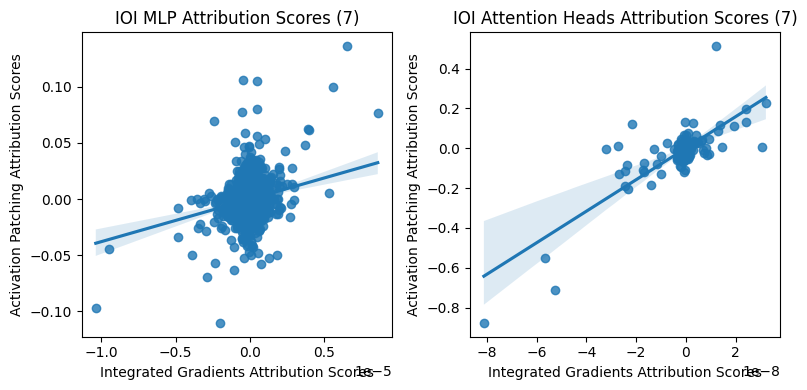

Correlation coefficient for neurons: 0.20726089775365947
Correlation coefficient for attention heads: 0.802071069318759


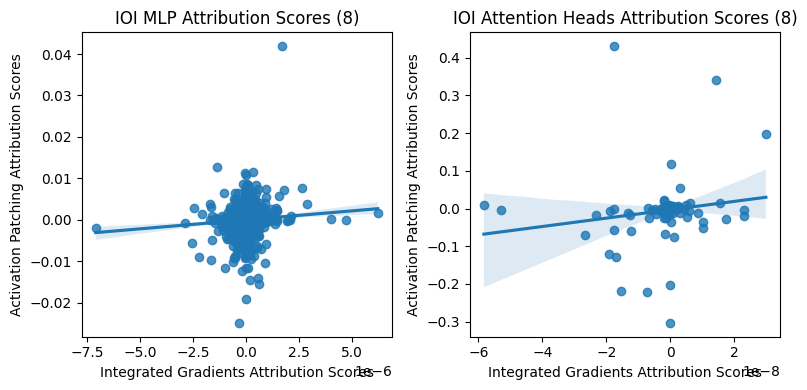

Correlation coefficient for neurons: 0.07880491059166742
Correlation coefficient for attention heads: 0.1589546626232069


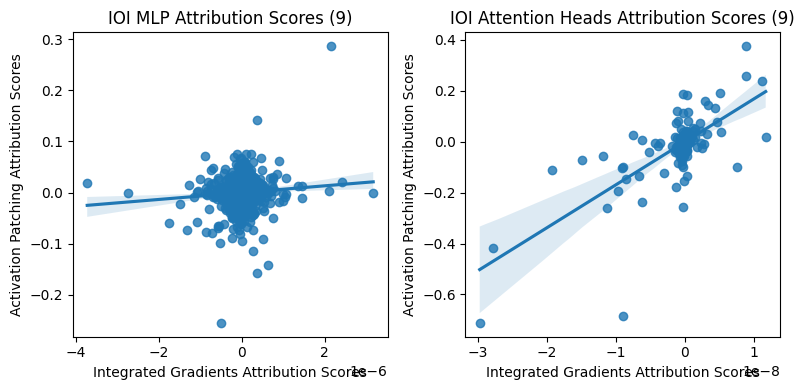

Correlation coefficient for neurons: 0.08759404831945791
Correlation coefficient for attention heads: 0.7074616983682992


In [40]:
plot_attn_comparison(ioi_split_ig_attn, ioi_ap_attn, Task.IOI, model)
plot_correlation(ioi_split_ig_mlp, ioi_ap_mlp, ioi_split_ig_attn, ioi_ap_attn, Task.IOI)